<a href="https://colab.research.google.com/github/nealresearch/Segmentanything/blob/main/cloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install laspy[laszip]
!pip install torch
!pip install segment-anything
!pip install torchvision
!pip install GDAL

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls "/content/drive/MyDrive/literature"

AnHavelclean.las	image_f.tif	 onedimension.jpeg
anHavel.laz		image.JPG	 potsdam.laz
Braun.laz		image.tif	 potsdampark.laz
braunsmall.laz		model.yml.gz	 RandomForest.zip
Brauschweig1_iter1.las	my_polygons.cpg  sam_vit_h_4b8939.pth
digi_twin.laz		my_polygons.dbf  sam_vit_l_0b3195.pth
edge1.jpeg		my_polygons.prj  Test.tif
edge.jpeg		my_polygons.shp
image_f_1.tif		my_polygons.shx


In [1]:
import laspy
import numpy as np
import cv2
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

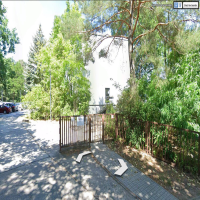

In [2]:
image = cv2.imread("/content/drive/MyDrive/highway/SAM.JPG")
resized = cv2.resize(image, (200,200), interpolation = cv2.INTER_AREA)
cv2_imshow(resized)



In [3]:
import torch
from torchvision.transforms import ToTensor

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

In [4]:
sam_checkpoint = "/content/drive/MyDrive/literature/sam_vit_h_4b8939.pth"
model_type = "vit_h"
# device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
# sam.to(device=device)

In [5]:
# move the model to GPU
sam = sam.to('cuda')

# Now, the model will use the GPU
mask_generator_ = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

# Before generating masks, make sure to move your image to GPU as well

masks = mask_generator_.generate(resized)

print(len(masks))


102


In [6]:
import cv2

polygons_list = []
for mask in masks:
    # Get the actual mask from the dictionary
    actual_mask = mask['segmentation']

    # Find contours in the mask. Note: you might need to convert the mask to uint8 first
    contours, _ = cv2.findContours((actual_mask * 255).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    polygons = []
    for contour in contours:
        # Approximate the contour to a polygon
        epsilon = 0.02 * cv2.arcLength(contour, True)  # 2% of the contour perimeter
        polygon = cv2.approxPolyDP(contour, epsilon, True)
        polygons.append(polygon)

    polygons_list.append(polygons)

In [11]:

# !pip install geopandas
# import geopandas as gpd
# from shapely.geometry import Polygon

# # Assuming polygons_list is a list of polygons where each polygon is represented by a list of points
# geometries = [Polygon(polygon.reshape(-1, 2)) for polygons in polygon_list for polygon in polygons]

# # Create a GeoSeries from the geometries and then convert it to a GeoDataFrame
# gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(geometries))

# # Write the GeoDataFrame to a shapefile
# gdf.to_file("output.shp")

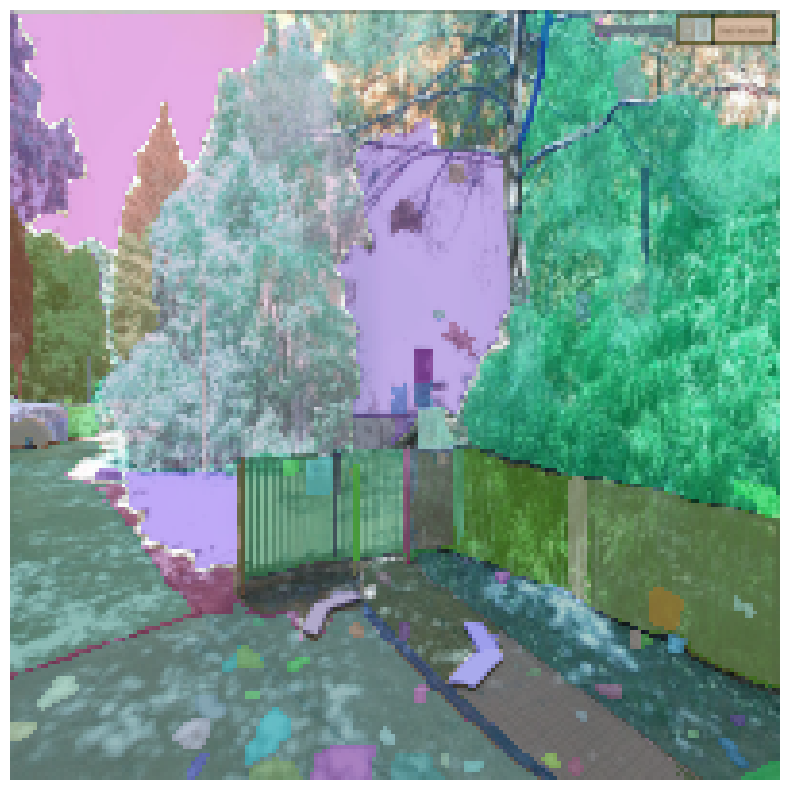

In [7]:
import matplotlib.pyplot as plt
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))


plt.figure(figsize=(10,10))
plt.imshow(resized)
show_anns(masks)
plt.axis('off')
plt.show()